Import Required Libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve

import shap
import warnings
warnings.filterwarnings("ignore")

Load and Explore Dataset

In [33]:
# Load dataset
df = pd.read_csv('bank-additional.csv', sep=';')

# Basic info
print("Shape:", df.shape)
print(df.info())

# Check target balance
print(df['y'].value_counts(normalize=True))

# Preview data
df.head()

Shape: (4119, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx  

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


Exploratory Data Analysis

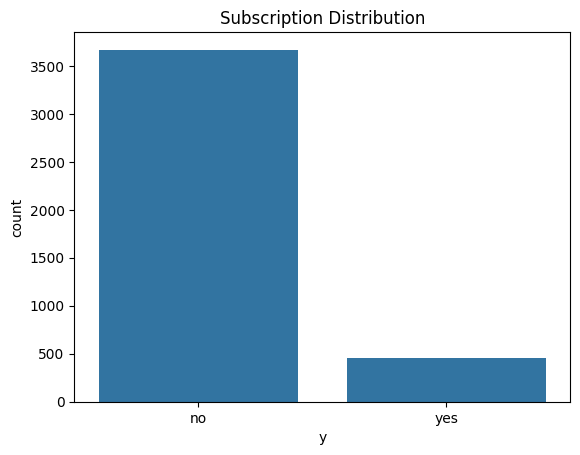

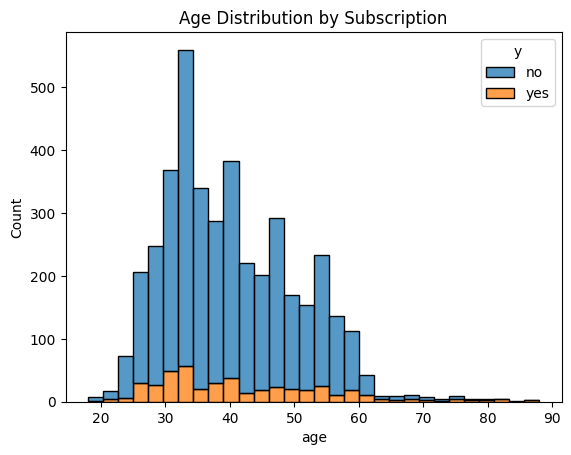

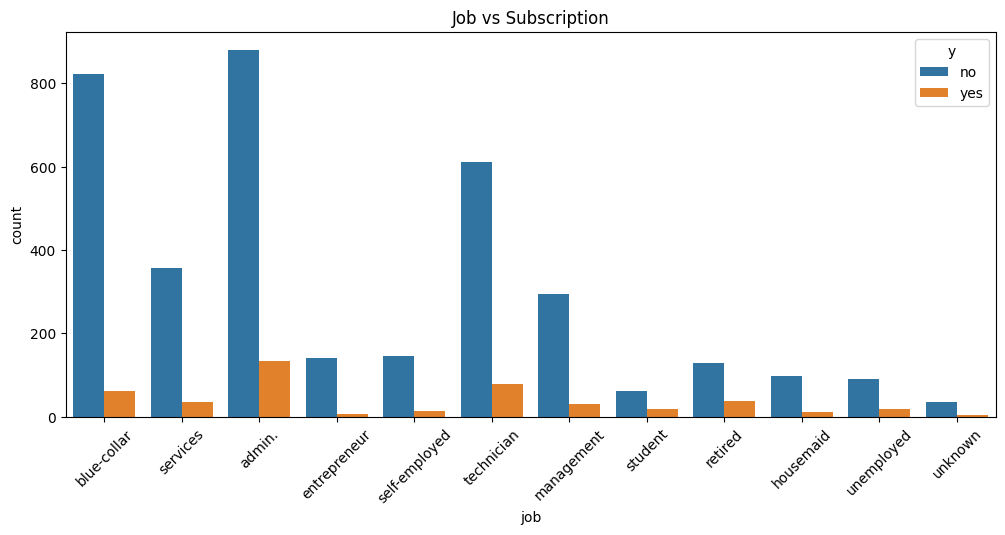

In [34]:
# Target variable distribution
sns.countplot(data=df, x='y')
plt.title("Subscription Distribution")
plt.show()

# Age vs Subscription
sns.histplot(data=df, x='age', hue='y', bins=30, multiple='stack')
plt.title("Age Distribution by Subscription")
plt.show()

# Job vs Subscription
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='job', hue='y')
plt.title("Job vs Subscription")
plt.xticks(rotation=45)
plt.show()

Encode Categorical Features

In [35]:
# Encode target variable
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Split features and target
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

Train-Test Split & Scaling

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Logistic Regression Model

In [37]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

Random Forest Model

In [38]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

Evaluation: Confusion Matrix, F1, ROC

Logistic Regression:
F1 Score: 0.49032258064516127
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       732
           1       0.60      0.41      0.49        92

    accuracy                           0.90       824
   macro avg       0.77      0.69      0.72       824
weighted avg       0.89      0.90      0.90       824



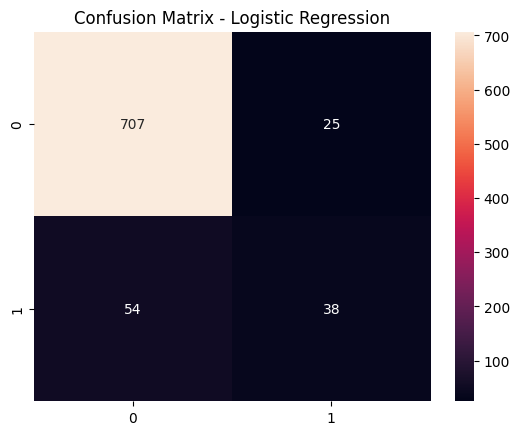

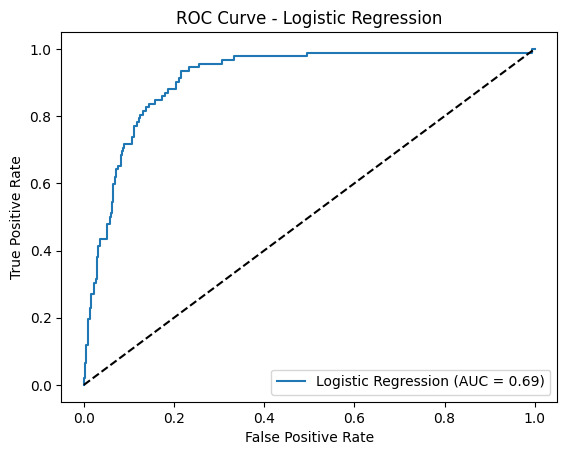

In [39]:
# Logistic Regression Evaluation
print("Logistic Regression:")
print("F1 Score:", f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ROC Curve - Logistic Regression
fpr, tpr, _ = roc_curve(y_test, lr.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_lr)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

Random Forest:
F1 Score: 0.43478260869565216
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       732
           1       0.65      0.33      0.43        92

    accuracy                           0.91       824
   macro avg       0.79      0.65      0.69       824
weighted avg       0.89      0.91      0.89       824



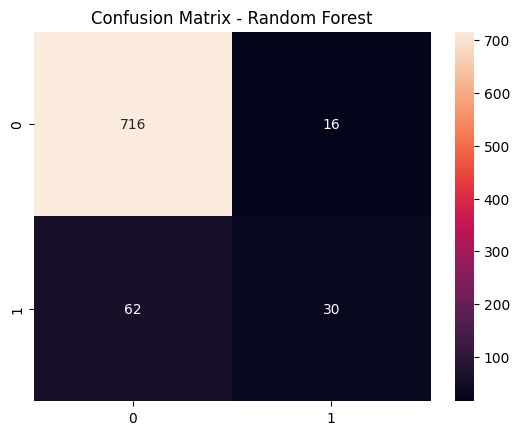

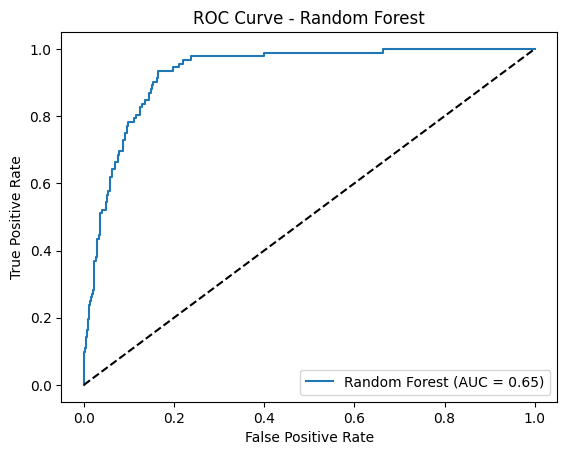

In [40]:
# Random Forest Evaluation
print("Random Forest:")
print("F1 Score:", f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ROC Curve - Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_rf)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

SHAP Explainability (5 Samples)

Explanation for Test Sample 1:


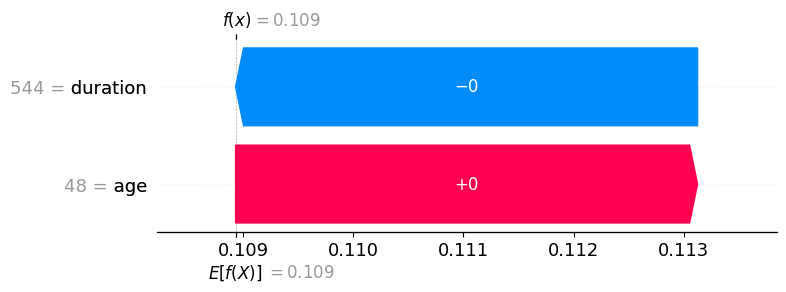

Explanation for Test Sample 2:


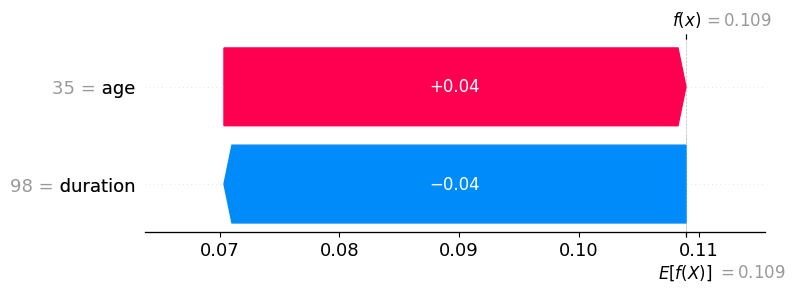

Explanation for Test Sample 3:


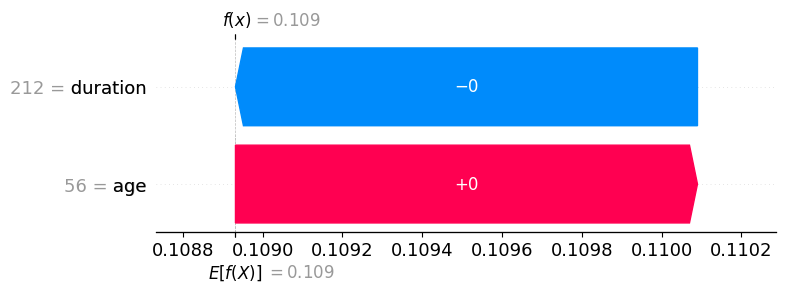

Explanation for Test Sample 4:


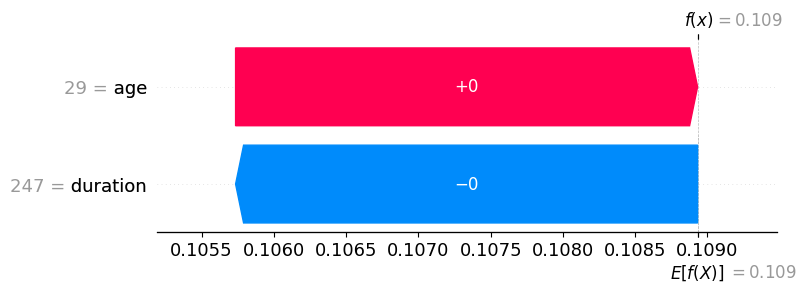

Explanation for Test Sample 5:


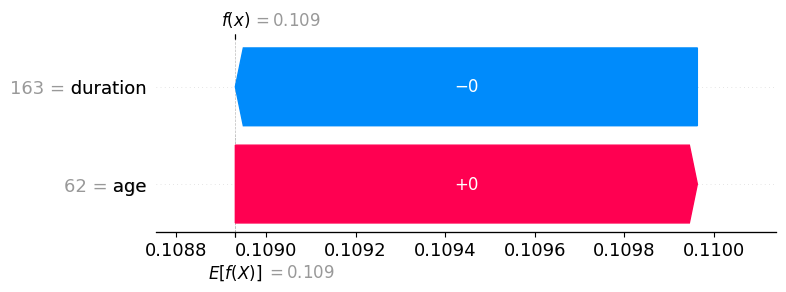

In [41]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Show SHAP explanation for first 5 samples
shap.initjs()
for i in range(5):
    print(f"Explanation for Test Sample {i+1}:")
    shap.plots.waterfall(shap.Explanation(values=shap_values[1][i],
                                          base_values=explainer.expected_value[1],
                                          data=X_test.iloc[i],
                                          feature_names=X_test.columns))